
# Code Walkthrough: Hong Kong International Airport


The following code shows how I made the visualizations in my Medium article, exploring the [Hong Kong International Airport's Passenger Data](https://medium.com/@rebecca.truong)


---

## Hong Kong Airport Dataset

Source: [Hong Kong Civil Aviation Department](https://www.cad.gov.hk/english/statistics.html)  
Last Updated on June 1st, 2023

The original dataset includes arrivals and departures for passengers, aircraft, and freight. I am only interested in the passengers, so I will only load columns related to passenger count. Passengers includes people entering and leaving Hong Kong under "Arrival" and "Departure". "Total" is the sum of arrivals and departures. Passengers can mean Hong Kong residents, leisure travelers, business travelers, as well as former residents or emigrants. Each row is a record of a month beginning in Jan 1998 to May 2023. 

In [1]:
# set up environment 

# import libraries & modules
# numpy & pandas
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype 

# datetime 
import datetime
from datetime import datetime

# regex
import re  

# matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

# seaborn
import seaborn as sns
import seaborn.objects as so

In [2]:
# load hong kong international airport dataset
    # we only want columns related to Passenger count
    # read date columns in as pd.datetime format

hk_air = pd.read_excel(r"C:\Users\Johnny\Desktop\Portfolio\Hong Kong\Hong Kong Air Traffic.xlsx",
                       header=[7], usecols=[0,1,7,8,9], index_col=[0], 
                       skipfooter=13, skiprows=list(range(8,35)),
                       parse_dates={'YearMonth': [0,1]}
                      ).rename(columns= {'Total.1':'Total'}).reset_index()  
hk_air.head()

,YearMonth,Arrival,Departure,Total
0,1998-01-01,1029744,1200708,2230452
1,1998-02-01,1091947,913061,2005008
2,1998-03-01,1070547,1099234,2169781
3,1998-04-01,1184956,1151549,2336505
4,1998-05-01,1051369,1077758,2129127


In [3]:
# check column data types
hk_air.dtypes

YearMonth    datetime64[ns]
Arrival               int64
Departure             int64
Total                 int64
dtype: object

In [4]:
# convert YearMonth to np.datetime64 format for plotting
hk_air['YearMonthnp'] = hk_air['YearMonth'].map(lambda x: mdates.date2num(x))

# rearrange columns so that YearMonthnp is in front
hk_air = hk_air.iloc[:,[4, 0, 1, 2, 3]]
hk_air.head()

,YearMonthnp,YearMonth,Arrival,Departure,Total
0,10227.0,1998-01-01,1029744,1200708,2230452
1,10258.0,1998-02-01,1091947,913061,2005008
2,10286.0,1998-03-01,1070547,1099234,2169781
3,10317.0,1998-04-01,1184956,1151549,2336505
4,10347.0,1998-05-01,1051369,1077758,2129127


### Hong Kong Events Spreadsheet
I want to mark the dates of certain events in Hong Kong, so I created a spreadsheet listing the dates and event. 

References are linked the article. The [Oxford COVID-19 Government Response Tracker](https://ourworldindata.org/covid-international-domestic-travel) was especially helpful for drawing the timeline of border closures and political events. I imported Oxford University's dataset into Google Sheets and cleaned the data to only include Hong Kong and the events I wanted to focus on. 

In [5]:
# load csv of hk events & dates
hk_events = pd.read_csv(
    r"C:\Users\Johnny\Desktop\Portfolio\Hong Kong\Hong Kong COVID & Government - hkevents.csv",
    usecols=[0,1],
    parse_dates=[0]
)
hk_events.head()

,Date,Event
0,1984-04-01,Sino-British Treaty Signed
1,1997-07-01,Hong Kong Handover
2,2003-07-01,First Proposal of National Security Law
3,2012-09-01,School Curricula Change to China Patriotism
4,2014-08-31,Umbrella Movement Ignited


In [6]:
# reset hk_event dates to the first of the month
# merge with hk_air on YearMonthnp to include passenger ct

# prep dates column for merging
hk_events['YearMonth'] = hk_events['Date'] + pd.tseries.offsets.MonthBegin(0)
hk_events['YearMonthnp'] = hk_events['YearMonth'].map(lambda x: mdates.date2num(x))

In [7]:
# merge to add passenger ct
hk_events = hk_events.merge(hk_air[['YearMonthnp', 'Total']], on='YearMonthnp', how='left')
hk_events = hk_events.sort_values(by='YearMonthnp').reset_index(drop=True)

#reorder columns 
hk_events = hk_events[['YearMonth', 'YearMonthnp', 'Total', 'Event']]
hk_events.head()

,YearMonth,YearMonthnp,Total,Event
0,1984-04-01,5204.0,NaN,Sino-British Treaty Signed
1,1997-07-01,10043.0,NaN,Hong Kong Handover
2,2003-07-01,12234.0,2401716.0,First Proposal of National Security Law
3,2012-09-01,15584.0,4335239.0,School Curricula Change to China Patriotism
4,2014-09-01,16314.0,5004561.0,Umbrella Movement Ignited


In [8]:
# keep only relevant rows for plotting
hk_events2 = hk_events.loc[[4,5,6,7,12,17]].reset_index(drop=True)
hk_events2

,YearMonth,YearMonthnp,Total,Event
0,2014-09-01,16314.0,5004561.0,Umbrella Movement Ignited
1,2019-06-01,18048.0,6319690.0,Pro-Democracy Protests Sparked
2,2020-01-01,18262.0,5701788.0,Concerns about COVID Arise
3,2020-04-01,18353.0,31739.0,Borders Close to Travelers
4,2021-03-01,18687.0,58245.0,Pro-Democracy Figures Arrested
5,2023-01-01,19358.0,2058741.0,Borders Open to Travelers


---
## Setup for Plotting Defaults
I changed the default matplotlib plotting parameters and palette so the graphs could look the way I want them. Then I made a few adjustments to each individual graph. 

In [9]:
# set cities as ordered categories so that colors stay mapped to the same city
city_order=['London', 'San Francisco', 'Seoul', 'Hong Kong']

In [10]:
# for reference
# city_palette={'London': 'indianred',
#               'San Francisco': 'orange',
#               'Seoul': 'mediumseagreen',
#               'steelblue': 'Hong Kong'
#              }

custom_palette = sns.color_palette(
    palette=['indianred', 'orange', 'mediumseagreen', 'dodgerblue'], as_cmap=True)
sns.set_palette(custom_palette)

sns.set_color_codes(palette='muted')  # Change how matplotlib color shorthands are interpreted. 

In [11]:
sns.set_style('whitegrid')

axes_spine = {'right': False,
              'left': False,
              'top': False,
              'bottom': False}

font = {'family' : 'Tahoma',
        'weight' : 'light',
        'size'   : 15}

ytick = {'left': False,
         'right': False,
         'major.pad': 10}

xtick = {'bottom': True,
         'major.width': 0.5,
         'major.size': 10,
         'major.pad': 10}

axeskwarg = {'labelpad': 15,
             'labelsize': 20,
             'titlesize': 15,
             'titleweight': 'normal',
             'titlepad': 10,
             'titlelocation': 'right'}

figurekwarg = {'subplot.wspace': 0.9,
               'subplot.hspace': 0.2,
               'autolayout': True
              }

plt.rc('axes.spines', **axes_spine)
plt.rc('font', **font)
plt.rc('ytick', **ytick)
plt.rc('xtick', **xtick)
plt.rc('axes', **axeskwarg)
plt.rc('figure', **figurekwarg)

---
## Plot Hong Kong Monthly Air Traffic

I will plot the Hong Kong passenger count by month. Then I will overlay a scatter plot, marking the dates of certain events. I decide to limit the graph to starting in January 2014 because the first major political event occured in 2014.

In [12]:
mdates.date2num(pd.to_datetime('2014-01-01')) # Jan 2014 in numpy format

16071.0

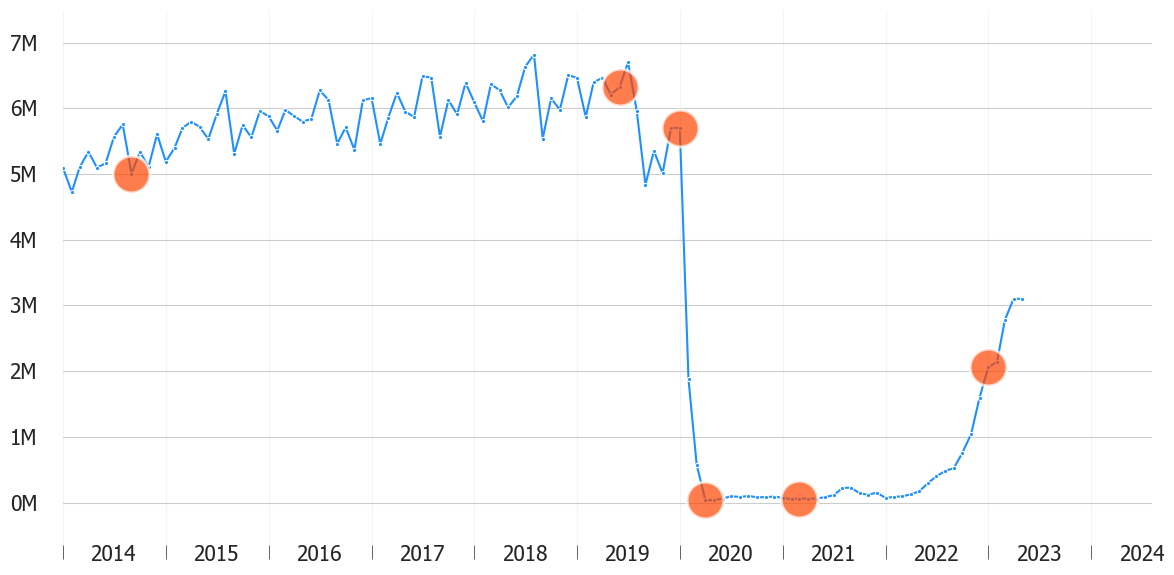

In [13]:
# plot Hong Kong air traffic with special dates marked

f, ax = plt.subplots(figsize=(12,6))


sns.lineplot(data=hk_air,
             x='YearMonthnp',
             y='Total',
             color='dodgerblue',
             marker='.'
            )
sns.scatterplot(data=hk_events2,
                x='YearMonthnp',
                y='Total',
                color='orangered',
                alpha=0.7,
                s=700,
                zorder=2.5
               )

"x-ticks - Year labeled in btw gridlines"
# years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months_fmt = mdates.DateFormatter('%b')

# Month Label
ax.xaxis.set_major_locator(mdates.MonthLocator(1))
ax.xaxis.set_major_formatter(months_fmt)
ax.tick_params(axis='x', which='major', labelbottom=False)

# Year Label
ax.xaxis.set_minor_locator(mdates.MonthLocator(7))
ax.xaxis.set_minor_formatter(years_fmt)
ax.tick_params(axis='x', which='minor', labelsize=15, length=0, pad=0)

# Month grid
ax.grid(axis='x', which='major', visible=True, alpha=0.2)  
ax.grid(axis='x', which='minor', visible=False)  

# set x-lim to only the data range
ax.set_xlim(16071.0)

# y-ticks format: 7e6 -> 7
def million(x, pos):
    'The two args are the value and tick position'
    return '%1.fM' % (x * 1e-6)

formatter = FuncFormatter(million)
ax.yaxis.set_major_formatter(formatter)
ax.margins(y=0.1)
ax.tick_params(axis='y', which='major', labelsize=15, pad=15)

# axis labels
ax.set_ylabel(None)
ax.set_xlabel(None);

In [14]:
# f.savefig('Viz\HKMonthlyAir.png', bbox_inches='tight', dpi=1200)

In [15]:
"Annotations looked ugly but were useful as a template for my final edits"

"set up kwarg"
# arrowprops = dict(
#     arrowstyle="-", color='grey')

# annotkwarg = {'textcoords':'figure fraction',
#               'ha':'center',
#               'va':'bottom',
#               'size':15,
#               'arrowprops': arrowprops}

"Umbrella Movement"
# xdata, ydata = 16314.0, 5004561.0
# ax.annotate(
#     '2014-Aug\nUmbrella\nMovement',
#     (xdata, ydata),
#     xytext=(0.15,0.4), 
#     **annotkwarg
#     )

"Pro-Democracy Protests"
# xdata, ydata = 18048.0, 6319690.0
# ax.annotate(
#     '2019-Jun\nPro-Democracy\nProtests',
#     (xdata, ydata),
#     xytext=(0.50,0.8), 
#     **annotkwarg
#     )

"Concerns about COVID Arise"
# xdata, ydata = 18262.0, 5701788.0
# ax.annotate(
#     '2020-Jan\nCOVID Concerns\nArise',
#     (xdata, ydata),
#     xytext=(0.65,0.7), 
#     **annotkwarg
#     )

"Borders Close to Travelers"
# xdata, ydata = 18353.0, 31739.0
# ax.annotate(
#     '2020-Apr\nBorders Close',
#     (xdata, ydata),
#     xytext=(0.5,0.12), 
#     **annotkwarg
#     )

"Pro-Democracy Figures Arrested"
# xdata, ydata = 18687.0, 58245.0
# ax.annotate(
#     '2020-Aug\nPro-Democracy\nFigures Arrested',
#     (xdata, ydata),
#     xytext=(0.7,0.2), 
#     **annotkwarg
#     )

"Borders Open to Travelers"
# xdata, ydata = 19358.0, 2058741.0
# ax.annotate(
#     '2021-Jan\nBorders Open',
#     (xdata, ydata),
#     xytext=(0.9,0.27), 
#     **annotkwarg
#     )

'Borders Open to Travelers'

---
## Plotting Hong Kong within the context of Global Air Traffic

Source: [International Civil Aviation Organization](https://data.worldbank.org/indicator/IS.AIR.PSGRend=2021&name_desc=false&start=1970&type=shaded&view=chart)  
Last Updated in January 2022

The World Bank publishes annual data on air traffic for 266 countries from 1970 to 2021.Since the data is aggregated by year, I also grouped the Hong Kong dataset by year for comparison. 

In [16]:
# load World Bank dataset

world_air = pd.read_csv(r"C:\Users\Johnny\Desktop\Portfolio\Hong Kong\world_bank_air_traffic\API_IS.AIR.PSGR_DS2_en_csv_v2_5454874.csv", 
                       header= 2,
                       usecols= list(range(0,2)) + list(range(14,66))  #drop empty columns
                       )
world_air.head()

,Country Name,Country Code,1970,1971,1972,1973,1974,1975,1976,1977,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,223502.00,2.742800e+05,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,3418300.0,3775300.0,4074500.0,4808000.0,5126100.0,5333100.0,6040400.0,5798900.0,...,3.583868e+07,3.511246e+07,3.635076e+07,39154692.0,41553429.0,45423814.08,5.261396e+07,5.485142e+07,1.916604e+07,2.405759e+07
2,Afghanistan,AFG,84700.0,97400.0,104900.0,96600.0,96100.0,99000.0,101700.0,111200.0,...,1.737962e+06,2.044188e+06,2.209428e+06,1929907.0,1917924.0,1647425.00,1.125367e+06,1.066747e+06,4.490410e+05,2.932130e+05
3,Africa Western and Central,AFW,1167000.0,1238100.0,1285700.0,1453300.0,1685700.0,1987500.0,2540000.0,2962100.0,...,9.570162e+06,8.677884e+06,8.030237e+06,8696300.0,8129874.0,8837017.00,1.233777e+07,1.138491e+07,5.328945e+06,7.425487e+06
4,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,155400.0,282700.0,...,1.132424e+06,1.321872e+06,1.409952e+06,1244491.0,1482546.0,1375523.00,1.516628e+06,1.436959e+06,3.566950e+05,3.114880e+05


In [17]:
# create table for world summary stats
world = world_air[world_air['Country Name'] == 'World']
world = pd.melt(
    world, id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='Passenger Count').drop(
    columns=['Country Name', 'Country Code'])

world.head()

,Year,Passenger Count
0,1970,310441392.0
1,1971,331604904.0
2,1972,NaN
3,1973,401571800.0
4,1974,421145200.0


In [18]:
# convert world['Year'] to int64
world['Year'] = world['Year'].astype('int64')
world['Year'].head()

0    1970
1    1971
2    1972
3    1973
4    1974
Name: Year, dtype: int64

In [19]:
# prepare Hong Kong Year tb

# group by year
hk_year = hk_air.iloc[:,1:].groupby(pd.Grouper(key='YearMonth', freq='Y')
                         )['Total'].sum().reset_index().rename(columns={'YearMonth': 'Year', 'Total': 'Passenger Count'})

# convert Yeardt to np.datetime64 format
hk_year['Year'] = hk_year['Year'].dt.year
hk_year.head()

,Year,Passenger Count
0,1998,27208792
1,1999,29062570
2,2000,32130712
3,2001,32026944
4,2002,33451572


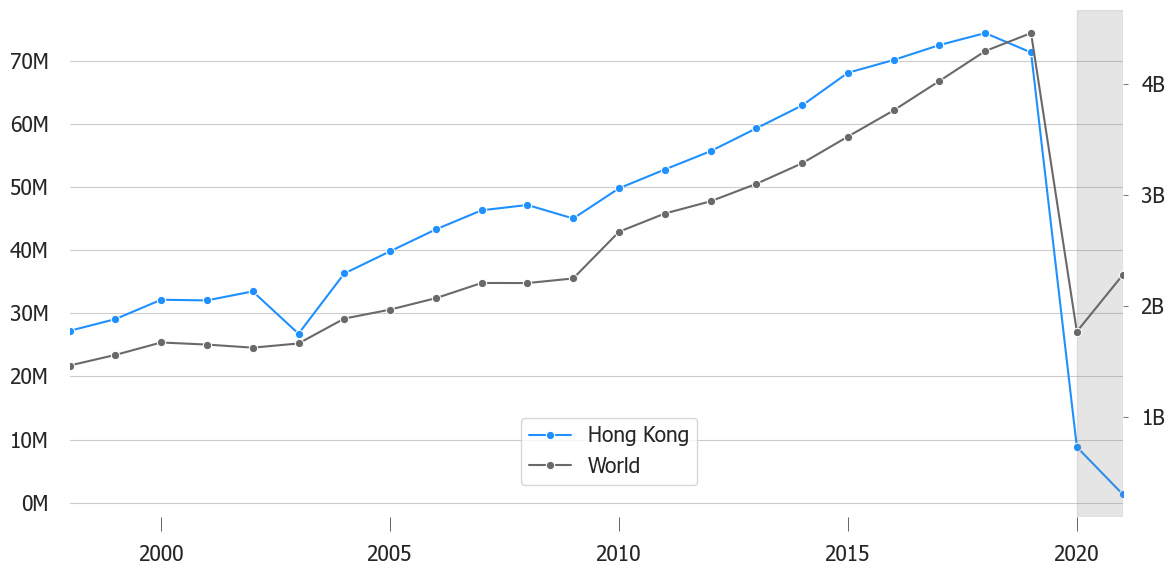

In [20]:
# Plot Hong Kong & World on twin y axis
# limit 1998-2021 (world data for 2022 onwards is not avail)

e, ax1 = plt.subplots(figsize=(12,6))

color1 = 'dodgerblue'
color2 = 'dimgrey'

"HONG KONG PLOT"
sns.lineplot(x='Year', y='Passenger Count', data=hk_year, ax=ax1,
             marker='o', color=color1,
             label='Hong Kong', legend=None
             )

# x-axis ticks on every year
ax1.set_xticks(ticks=np.arange(2000,2022,5))
ax1.set_xlim(left=1998, right=2021)
ax1.tick_params(axis='x', labelsize=15)

ax1.grid(axis='x', visible=False)
ax1.grid(axis='y', which='major', visible=True)

# y-tick format, 1M
formatter = FuncFormatter(million)
ax1.yaxis.set_major_formatter(formatter)
ax1.set_xlabel(None)
ax1.set_ylabel(None)
ax1.tick_params(axis='y', length=0, pad=15, labelsize=15)


ax2 = ax1.twinx()  #  create a second axes that shares the same x-axis

"WORLD PLOT"
sns.lineplot(data=world, x='Year', y='Passenger Count', ax=ax2, 
             marker='o', color=color2,
             label='World', legend=None
             )

# y-tick format, 7e9 -> 1B
def billion(x, pos):
    'The two args are the value and tick position'
    return '%1.fB' % (x * 1e-9)
formatter = FuncFormatter(billion)
ax2.yaxis.set_major_formatter(formatter)
ax2.set(ylabel=None)
ax2.tick_params(axis='y', left=False, right=True, color='grey', labelsize=15)
ax2.grid(axis='y', which='major')
ax1.axvspan(2020,2021, alpha=0.2, color='grey', zorder=2)

"FIGURE LEGEND"
e.legend(bbox_to_anchor=(0.6, 0.3));

In [21]:
# e.savefig('Viz\HKWorldAir.png', bbox_inches='tight', dpi=1200)

---
## Plotting Hong Kong within the Context of Other International Cities

Sources: [Heathrow](https://www.heathrow.com/company/investor-centre/reports/traffic-statistics), 
[San Francisco](https://www.flysfo.com/about/media/facts-statistics/air-traffic-statistics), 
[Incheon](https://www.airport.kr/co/en/cpr/statisticCategoryOfTimeSeries.do)  
Last Updated in June 2023

I found updated passenger count by month for Heathrow Airport (London), San Francisco Airport, and Incheon Airport (Seoul). Fortunately the datasets were in English and consolidated into one sheet.

In [22]:
# San Francisco, United States

us_air = pd.read_csv(
    r"C:\Users\Johnny\Desktop\Portfolio\Hong Kong\International Airports\SFO_Air_Traffic.csv",
    usecols=[0,5,11],
    parse_dates=[0],
    thousands=','
)
us_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26156 entries, 0 to 26155
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Activity Period  26156 non-null  object
 1   GEO Summary      26156 non-null  object
 2   Passenger Count  26156 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 613.2+ KB


In [23]:
# convert columns into correct dtype
# Activity Period: convert to datetime
us_air['YearMonth'] = pd.to_datetime(us_air['Activity Period'], format='%Y%m')

In [24]:
# groupby month 
us_air = us_air.groupby('YearMonth')[['Passenger Count']].sum().reset_index()
us_air.head()

,YearMonth,Passenger Count
0,2005-07-01,3225769
1,2005-08-01,3195866
2,2005-09-01,2740553
3,2005-10-01,2770715
4,2005-11-01,2617333


In [25]:
us_air.tail()  # I realized that this csv file was not updated with the most recent months

,YearMonth,Passenger Count
208,2022-11-01,3654498
209,2022-12-01,3746158
210,2023-01-01,3360186
211,2023-02-01,3138399
212,2023-03-01,3867517


In [26]:
# add April and May stats to us_air 

new_rows = pd.DataFrame([(datetime.strptime('2023-04-01', '%Y-%m-%d'), 3985372),
                         (datetime.strptime('2023-05-01', '%Y-%m-%d'), 4374640)],
                        columns=['YearMonth', 'Passenger Count']
                       )
us_air = pd.concat([us_air, new_rows]).reset_index(drop=True)
us_air.tail()

,YearMonth,Passenger Count
210,2023-01-01,3360186
211,2023-02-01,3138399
212,2023-03-01,3867517
213,2023-04-01,3985372
214,2023-05-01,4374640


In [27]:
# Heathrow, United Kingdom
uk_air = pd.read_excel(
    r"C:\Users\Johnny\Desktop\Portfolio\Hong Kong\International Airports\Heathrow_Air_Traffic.xlsx",
    header=[2],
    usecols=[0,1]
)
uk_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       222 non-null    datetime64[ns]
 1   Passengers  222 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.6 KB


In [28]:
# rename columns to same as HK, US
uk_air = uk_air.rename(columns={
    'Month': 'YearMonth',
    'Passengers': 'Passenger Count'
}) 

In [29]:
# convert passenger ct to int64
uk_air['Passenger Count'] = uk_air['Passenger Count'].astype('int64')
uk_air

,YearMonth,Passenger Count
0,2005-01-01,5141123
1,2005-02-01,4753591
2,2005-03-01,5708627
3,2005-04-01,5573022
4,2005-05-01,5636621
...,...,...
217,2023-02-01,5195017
218,2023-03-01,6229634
219,2023-04-01,6398870
220,2023-05-01,6727259


In [30]:
# Incheon, South Korea 
sk_air = pd.DataFrame(
    pd.read_html(r"C:\Users\Johnny\Desktop\Portfolio\Hong Kong\International Airports\Incheon_Air_Traffic.xls")[0]
)
sk_air

year           month   Flight                    Passengers  \
               year           month  Arrival Departure    Total    Arrival   
0              2010              01     8537      8532    17069    1333697   
1              2010              02     7888      7928    15816    1309783   
2              2010              03     8640      8644    17284    1409828   
3              2010              04     8548      8567    17115    1316541   
4              2010              05     9082      9086    18168    1366559   
..              ...             ...      ...       ...      ...        ...   
171            2023              03    11931     11961    23892    2039130   
172            2023              04    12601     12617    25218    2023823   
173            2023              05    14085     14069    28154    2195137   
174  2023ë
 ìê³  2023ë
 ìê³    60522     60563   121085   10019979   
175           Total           Total  1815173   1814908  3630081  278596635   

                              Cargo                      
     Departure      Total   Arrival Departure     Total  
0      1409664    2743361     92122    110123    202245  
1      1261439    2571222     89592    107182    196774  
2      1341048    2750876    110029    131906    241935  
3      1313037    2629578    103203    126338    229542  
4      1350206    2716765    109573    131706    241279  
..         ...        ...       ...       ...       ...  
171    1869885    3909015    119878    117379    237257  
172    2024364    4048187    114959    108057    223016  
173    2199755    4394892    110864    106300    217164  
174    9907767   19927746    556658    530004   1086662  
175  277514836  556111471  17992781  18842110  36834891  

[176 rows x 11 columns]

In [31]:
# clean SK df 
sk_air = sk_air[['year', 'month','Passengers']]   # keep only columns related to passengers
sk_air.columns = sk_air.columns.to_flat_index()   # flatten multi-index column
sk_air.head()

,"(year, year)","(month, month)","(Passengers, Arrival)","(Passengers, Departure)","(Passengers, Total)"
0,2010,01,1333697,1409664,2743361
1,2010,02,1309783,1261439,2571222
2,2010,03,1409828,1341048,2750876
3,2010,04,1316541,1313037,2629578
4,2010,05,1366559,1350206,2716765


In [32]:
# keep only relevant columns
sk_air = sk_air.iloc[:,[0,1,4]]
sk_air.head()

,"(year, year)","(month, month)","(Passengers, Total)"
0,2010,01,2743361
1,2010,02,2571222
2,2010,03,2750876
3,2010,04,2629578
4,2010,05,2716765


In [33]:
# simplify column names
sk_air.columns = ['Year', 'Month', 'Passenger Count']  
sk_air.head()

,Year,Month,Passenger Count
0,2010,01,2743361
1,2010,02,2571222
2,2010,03,2750876
3,2010,04,2629578
4,2010,05,2716765


In [34]:
# There are summary rows in the dataset. We want to find the row index for them.
# display the entire SK df

# The scope of these changes made to
# pandas settings are local to with statement.
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                      ):
    print(sk_air)

               Year           Month  Passenger Count
0              2010              01          2743361
1              2010              02          2571222
2              2010              03          2750876
3              2010              04          2629578
4              2010              05          2716765
5              2010              06          2672367
6              2010              07          2989580
7              2010              08          3247493
8              2010              09          2756069
9              2010              10          2984474
10             2010              11          2733328
11             2010              12          2683812
12   2010ë ìê³  2010ë ìê³         33478925
13             2011              01          3017042
14             2011              02          2747788
15             2011              03          2659350
16             2011              04          2587178
17             2011              05          2

In [35]:
# get rid of summary rows 
sumrows = list(np.arange(12,169,13)) + [174, 175] # intervals of 13 b/c there are 12 months in a year
sumrows

[12, 25, 38, 51, 64, 77, 90, 103, 116, 129, 142, 155, 168, 174, 175]

In [36]:
sk_air = sk_air.drop(sumrows)

In [37]:
# create a new column called YearMonth
sk_air['YearMonth'] = sk_air['Year'] + sk_air['Month']

# convert YearMonth to datetime
sk_air['YearMonth'] = pd.to_datetime(sk_air['YearMonth'], format='%Y%m')  
sk_air = sk_air.drop(columns=['Year','Month']) 
sk_air = sk_air[['YearMonth', 'Passenger Count']]  # reorder columns
sk_air

,YearMonth,Passenger Count
0,2010-01-01,2743361
1,2010-02-01,2571222
2,2010-03-01,2750876
3,2010-04-01,2629578
4,2010-05-01,2716765
...,...,...
169,2023-01-01,3845153
170,2023-02-01,3730499
171,2023-03-01,3909015
172,2023-04-01,4048187


In [38]:
# now I want to see if all the tables are uniform

# display df's side by side
from IPython.display import display, HTML

css = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(css))

In [39]:
display(us_air.head())
display(uk_air.head())
display(sk_air.head())

,YearMonth,Passenger Count
0,2005-07-01,3225769
1,2005-08-01,3195866
2,2005-09-01,2740553
3,2005-10-01,2770715
4,2005-11-01,2617333


,YearMonth,Passenger Count
0,2005-01-01,5141123
1,2005-02-01,4753591
2,2005-03-01,5708627
3,2005-04-01,5573022
4,2005-05-01,5636621


,YearMonth,Passenger Count
0,2010-01-01,2743361
1,2010-02-01,2571222
2,2010-03-01,2750876
3,2010-04-01,2629578
4,2010-05-01,2716765


In [40]:
# make hk_air uniform with the other tables
hk_air = hk_air[['YearMonth','Total']].rename(columns={'Total': 'Passenger Count'})
hk_air.head()

,YearMonth,Passenger Count
0,1998-01-01,2230452
1,1998-02-01,2005008
2,1998-03-01,2169781
3,1998-04-01,2336505
4,1998-05-01,2129127


In [41]:
"""

Plot HK, US, UK, SK into one grid 

"""

'\n\nPlot HK, US, UK, SK into one grid \n\n'

In [42]:
# prepare table 

# add city name into columns
hk_air['City'] = 'Hong Kong'
us_air['City'] = 'San Francisco'
uk_air['City'] = 'London'
sk_air['City'] = 'Seoul'

In [43]:
# combine df into one 
city_air = pd.concat([hk_air, us_air, uk_air, sk_air], join="inner")
city_air.head()

,YearMonth,Passenger Count,City
0,1998-01-01,2230452,Hong Kong
1,1998-02-01,2005008,Hong Kong
2,1998-03-01,2169781,Hong Kong
3,1998-04-01,2336505,Hong Kong
4,1998-05-01,2129127,Hong Kong


In [44]:
# add YearMonthnp
city_air['YearMonthnp'] = city_air['YearMonth'].map(lambda x: mdates.date2num(x))
city_air.head()

,YearMonth,Passenger Count,City,YearMonthnp
0,1998-01-01,2230452,Hong Kong,10227.0
1,1998-02-01,2005008,Hong Kong,10258.0
2,1998-03-01,2169781,Hong Kong,10286.0
3,1998-04-01,2336505,Hong Kong,10317.0
4,1998-05-01,2129127,Hong Kong,10347.0


In [45]:
# find np version of Jan 2017 
mdates.date2num(pd.to_datetime('2017-01-01'))

17167.0

In [46]:
# find np version of May 2023
mdates.date2num(pd.to_datetime('2023-05-01'))

19478.0

In [47]:
city_air

,YearMonth,Passenger Count,City,YearMonthnp
0,1998-01-01,2230452,Hong Kong,10227.0
1,1998-02-01,2005008,Hong Kong,10258.0
2,1998-03-01,2169781,Hong Kong,10286.0
3,1998-04-01,2336505,Hong Kong,10317.0
4,1998-05-01,2129127,Hong Kong,10347.0
...,...,...,...,...
169,2023-01-01,3845153,Seoul,19358.0
170,2023-02-01,3730499,Seoul,19389.0
171,2023-03-01,3909015,Seoul,19417.0
172,2023-04-01,4048187,Seoul,19448.0


In [48]:
# sort cities according to their specified order so viz are consistent
city_air['City']=pd.Categorical(city_air['City'], city_order, ordered=True)
city_air = city_air.sort_values('City')
city_air.head()

,YearMonth,Passenger Count,City,YearMonthnp
84,2012-01-01,5169518,London,15340.0
122,2015-03-01,5950930,London,16495.0
123,2015-04-01,6144333,London,16526.0
124,2015-05-01,6342533,London,16556.0
125,2015-06-01,6675186,London,16587.0


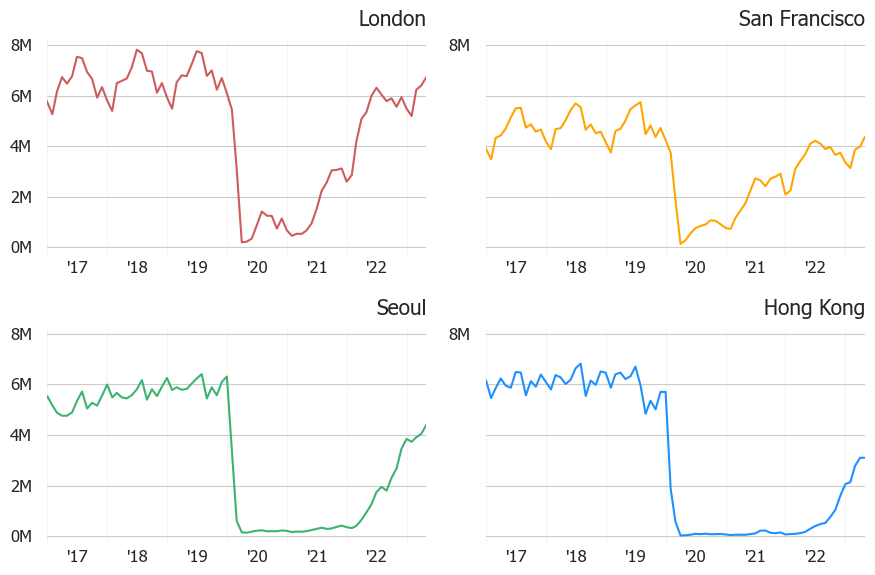

In [49]:
# Plot Monthy Air Traffic of Cities
    # 2017 - 2023

g = sns.FacetGrid(city_air,
                  col='City', col_wrap=2,
                  sharex=True, sharey=True,
                  hue='City',
                  xlim=(17167.0, 19478.0),
                  aspect=1.5
                 )
g.map_dataframe(sns.lineplot, x="YearMonthnp", y="Passenger Count")
g.set_titles(col_template='{col_name}',
             size=15,
             fontweight='normal'
            )

for ax in g.axes_dict.values():
    # axis labels
    ax.set_xlabel(None)  
    ax.set_ylabel(None)
    # x-ticks - Year labeled in btw gridlines
    years_fmt = mdates.DateFormatter('\'%y')
    months_fmt = mdates.DateFormatter('%b')
    # Month Label
    ax.xaxis.set_major_locator(mdates.MonthLocator(1))
    ax.xaxis.set_major_formatter(months_fmt)
    ax.tick_params(axis='x', which='major', labelbottom=False, length=0)
    # Year Label
    ax.xaxis.set_minor_locator(mdates.MonthLocator(7))
    ax.xaxis.set_minor_formatter(years_fmt)
    ax.tick_params(axis='x', which='minor', labelsize=12, length=0)
    # Month grid
    ax.grid(axis='x', which='major', visible=True, alpha=0.2)  
    ax.grid(axis='x', which='minor', visible=False)
    
    # y-ticks
    formatter = FuncFormatter(million)
    ax.yaxis.set_major_formatter(formatter)
    ax.tick_params(axis='y', pad=10, labelsize=12, length=1)
    ax.margins()


sns.despine(left=True, bottom=True);

In [50]:
# g.savefig('Viz\CityMonthlyAir2.png', bbox_inches='tight', dpi=1200)

---
## Plotting Percent Change from 2019

I compared 2023 months to their respective months in 2019 for each city.

In [52]:
mdates.date2num(pd.to_datetime('2019-01-01')) # find np version of Jan 2019 

17897.0

In [53]:
# prepare table
# only include 2019 onwards
city_recent = city_air[city_air['YearMonthnp'] >= 17897.0]
city_recent.head()

,YearMonth,Passenger Count,City,YearMonthnp
169,2019-02-01,5482288,London,17928.0
170,2019-03-01,6527489,London,17956.0
171,2019-04-01,6798212,London,17987.0
172,2019-05-01,6768903,London,18017.0
173,2019-06-01,7246563,London,18048.0


In [54]:
city_recent = city_recent.pivot_table(values='Passenger Count', index='YearMonth', columns='City')
city_recent.head()

City,London,San Francisco,Seoul,Hong Kong
YearMonth,,,,
2019-01-01,5927543.0,4156821.0,6252497.0,6460193.0
2019-02-01,5482288.0,3752763.0,5777502.0,5866706.0
2019-03-01,6527489.0,4599189.0,5882519.0,6396906.0
2019-04-01,6798212.0,4692941.0,5786717.0,6464336.0
2019-05-01,6768903.0,5008001.0,5820380.0,6209935.0


In [55]:
# 2019 compared to 2023
display(city_recent.head(6))
display(city_recent.tail(6))

City,London,San Francisco,Seoul,Hong Kong
YearMonth,,,,
2019-01-01,5927543.0,4156821.0,6252497.0,6460193.0
2019-02-01,5482288.0,3752763.0,5777502.0,5866706.0
2019-03-01,6527489.0,4599189.0,5882519.0,6396906.0
2019-04-01,6798212.0,4692941.0,5786717.0,6464336.0
2019-05-01,6768903.0,5008001.0,5820380.0,6209935.0
2019-06-01,7246563.0,5466688.0,6027624.0,6319690.0


City,London,San Francisco,Seoul,Hong Kong
YearMonth,,,,
2023-01-01,5481889.0,3360186.0,3845153.0,2058741.0
2023-02-01,5195017.0,3138399.0,3730499.0,2139047.0
2023-03-01,6229634.0,3867517.0,3909015.0,2776885.0
2023-04-01,6398870.0,3985372.0,4048187.0,3102000.0
2023-05-01,6727259.0,4374640.0,4394892.0,3099000.0
2023-06-01,7041157.0,NaN,NaN,NaN


### Creating a Percent Change Table
It's hard to gleam anything useful when looking at numbers so large, so let's calculate percent change from 2019.

In [59]:
city_pct = city_recent.pct_change(48, fill_method=None).round(decimals=4)  # calculate percent change from 2019, 4 years prior
city_pct =  city_pct.tail(6).head(5)  # keep only Jan 2023-May 2023
city_pct.index.name = 'Month'  # rename index as Month
city_pct = city_pct * 100  # convert values decimal -> percent
city_pct

City,London,San Francisco,Seoul,Hong Kong
Month,,,,
2023-01-01,-7.52,-19.16,-38.50,-68.13
2023-02-01,-5.24,-16.37,-35.43,-63.54
2023-03-01,-4.56,-15.91,-33.55,-56.59
2023-04-01,-5.87,-15.08,-30.04,-52.01
2023-05-01,-0.62,-12.65,-24.49,-50.10


In [60]:
# clean up table for presentation 

properties = {"width": "70px", "text-align": "center"}

city_pct.style\
    .format({                  # format values as percent
        "Hong Kong": "{:.0f}%",
        "London": "{:.0f}%",
        "San Francisco": "{:.0f}%",
        "Seoul": "{:.0f}%"
    })\
    .format_index('{:%b}')\
    .background_gradient(cmap='RdYlBu', axis=None)\
    .set_properties(**properties)

City,London,San Francisco,Seoul,Hong Kong
Month,,,,
Jan,-8%,-19%,-38%,-68%
Feb,-5%,-16%,-35%,-64%
Mar,-5%,-16%,-34%,-57%
Apr,-6%,-15%,-30%,-52%
May,-1%,-13%,-24%,-50%


### Plotting Percent Change

In [61]:
# prepare table

# convert wide format -> long format
long_citypct = pd.melt(city_pct.reset_index(),
                       id_vars='Month',
                       value_vars=city_order,
                       value_name='Percent Change',
                       var_name='City'
                      )

long_citypct['Month'] = long_citypct['Month'].dt.strftime('%b')
long_citypct

,Month,City,Percent Change
0,Jan,London,-7.52
1,Feb,London,-5.24
2,Mar,London,-4.56
3,Apr,London,-5.87
4,May,London,-0.62
5,Jan,San Francisco,-19.16
6,Feb,San Francisco,-16.37
7,Mar,San Francisco,-15.91
8,Apr,San Francisco,-15.08
9,May,San Francisco,-12.65


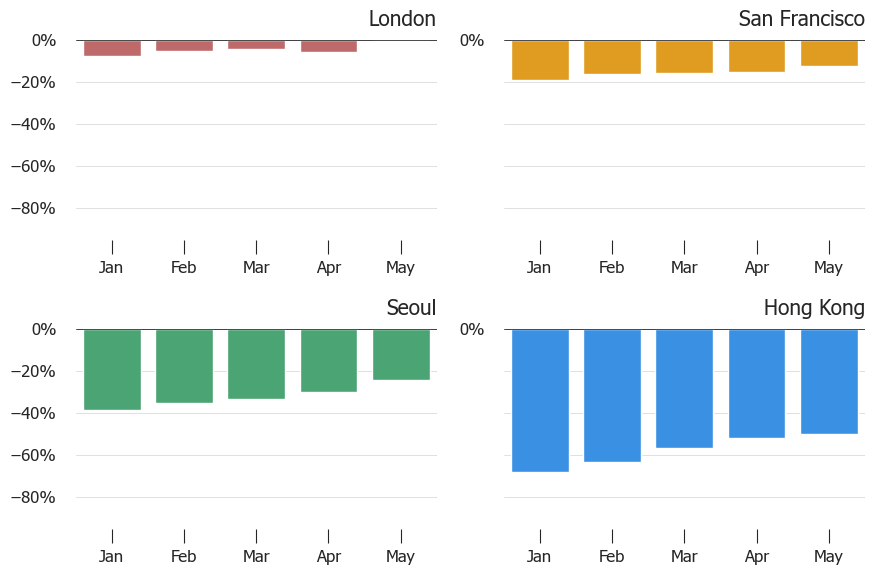

In [62]:
# plot %change 

j = sns.FacetGrid(long_citypct, col='City',
                  hue='City',
                  col_order=['London', 'San Francisco', 'Seoul', 'Hong Kong'],
                  col_wrap=2,
                  aspect=1.5,
                  sharex=True, sharey=True
                 )
j.map_dataframe(sns.barplot, x="Month", y="Percent Change",
#                 color='orangered',
                zorder=2
               )

# labels
j.set_titles(col_template='{col_name}',
             size=15,
             fontweight='normal'
            )  

for ax in j.axes_dict.values():
    
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.tick_params(bottom=True, labelbottom=True, labelsize=12) 
    ax.xaxis.set_tick_params(width=0.8, pad=5, labelsize=12)   
    
    ax.yaxis.set_major_formatter(ticker.PercentFormatter()) 
    ax.grid(axis='y', which='major', color='lightgrey', linewidth=0.5) 
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.margins(y=0.4)

sns.despine(left=True, bottom=True);

In [79]:
# j.savefig('Viz\AirTrafficRecovery2.png', bbox_inches='tight', dpi=1200)

## Final Edits

After I like how the graphs look, I export as png to my computer. In Canva, I add titles, subtitles, and annotations. 